<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/BCS_IBL_dataset_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and configuration of IBL packages

In [ ]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.3/993.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 18.1 MB/s eta 

In [ ]:
from one.api import ONE
import numpy as np

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


# Loading trials data for a single subject

In [ ]:
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL045/#2024-04-10#/_ibl_subjectTrials.table.pqt: 100%|██████████| 9.27M/9.27M [00:00<00:00, 12.8MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL045/_ibl_subjectSessions.table.pqt: 100%|██████████| 8.98k/8.98k [00:00<00:00, 55.9kB/s]


The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://www.google.com/url?q=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg%2Fedit%23heading%3Dh.ls81qq9ihg4x) for more information about this dataset.

In [ ]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')

# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL045 has 76 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.3.1      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5    12
_iblrig_tasks_trainingChoiceWorld6.3.1    11
_iblrig_tasks_biasedChoiceWorld6.2.5       6
_iblrig_tasks_ephysChoiceWorld6.2.5        3
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_ephysChoiceWorld6.4.0        2
_iblrig_tasks_trainingChoiceWorld6.2.0     1
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
Name: count, dtype: int64


We can get the trials data for an individual session of choice, here a the first session using the `biasedChoiceWorld` protocol

In [ ]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

/usr/local/lib/python3.11/dist-packages/brainbox/behavior/training.py:561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sum(trials['feedbackType'][easy_trials] == 1) / easy_trials.shape[0]


Number of trials for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 682
Performance easy for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 0.9457364341085271


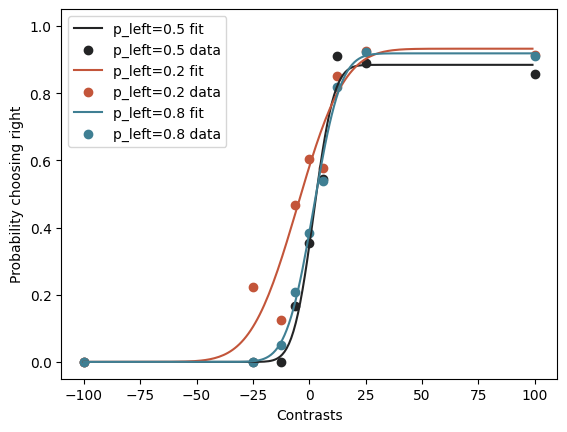

In [ ]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')